In [209]:
import pandas as pd
import optuna
import lightgbm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import log_loss, classification_report,precision_recall_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample


SEED = 123

# Let's get the dataset

In [137]:
df = pd.read_csv('dataset.csv')
df.head()

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,last__fc,n__fc,mean_n_owner_included__fc,mean_duration_in__fc,mean_duration_out__fc,mean_n_recipients__fc,...,n__fo,mean_n_owner_included__fo,mean_duration_in__fo,mean_duration_out__fo,mean_n_recipients__fo,mean_n_to__fo,first_created_date,CreatedDate__fq,opp_estimated_close_date__fq,target
0,0061300001ADuHtAAL,2022-08-29,False,2021-02-21 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-21 20:53:45,2021Q3,2023Q1,False
1,0061300001ADuHtAAL,2022-08-29,False,2021-02-22 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-21 20:53:45,2021Q3,2023Q1,False
2,0061300001ADuHtAAL,2022-08-29,False,2021-02-23 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-21 20:53:45,2021Q3,2023Q1,False
3,0061300001ADuHtAAL,2022-08-29,False,2021-02-24 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-21 20:53:45,2021Q3,2023Q1,False
4,0061300001ADuHtAAL,2022-08-29,False,2021-02-25 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-21 20:53:45,2021Q3,2023Q1,False


In [138]:
train_columns = ['n__fc', 'n__tc', 'n__fo', 'mean_n_recipients__fc', 'mean_n_recipients__tc', 'mean_n_recipients__fo']
train_columns

['n__fc',
 'n__tc',
 'n__fo',
 'mean_n_recipients__fc',
 'mean_n_recipients__tc',
 'mean_n_recipients__fo']

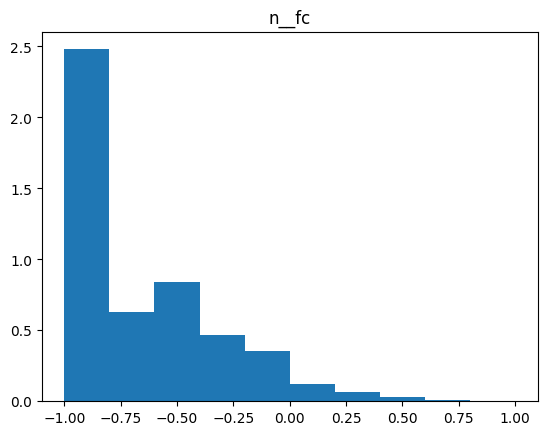

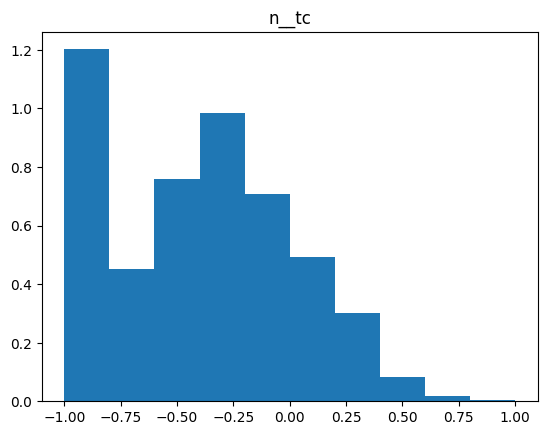

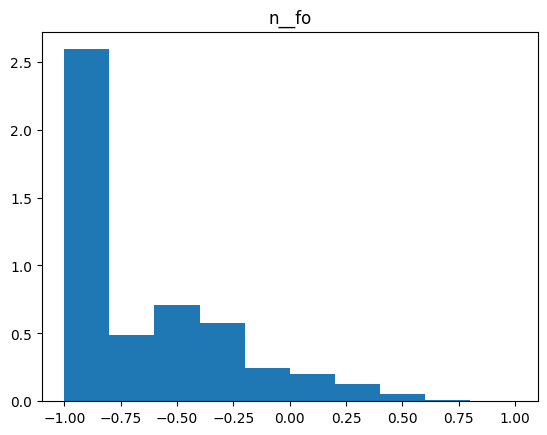

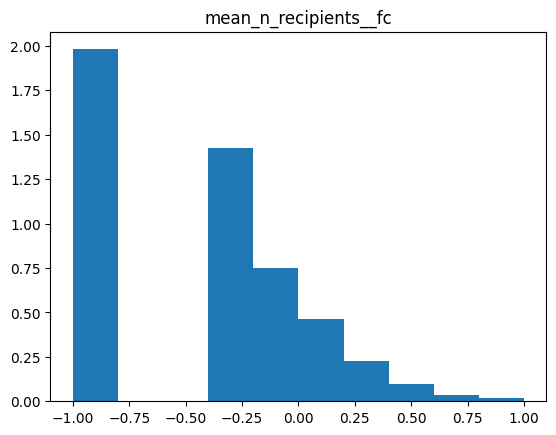

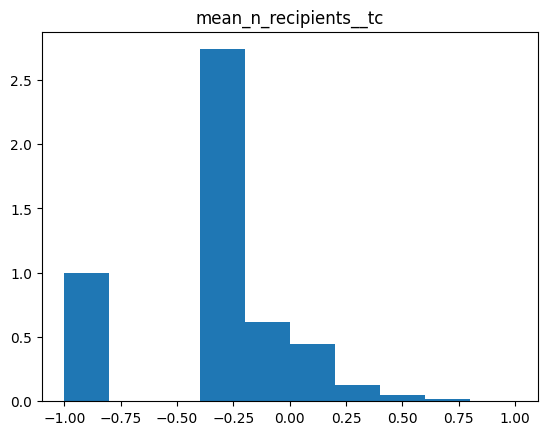

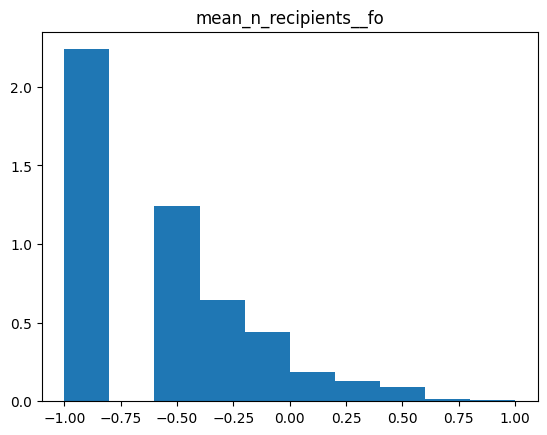

In [336]:
# df2 will contain log of the feature because the distributions are very skewed
df2 = df.copy()
for feature in train_columns:
    df2[feature] = np.log1p(df2[feature])

scaler = MinMaxScaler(feature_range=(-1,1))  # rescaling makes SVC MUCH MUCH faster while not imparting LGBM
scaler.fit(df2[train_columns])

df2[train_columns] = scaler.transform(df2[train_columns])

for feature in train_columns:
    plt.hist(df2[feature], density=True)
    plt.title(feature)
    plt.show()



In [337]:
# this column shows the % of the samples closed successfully
print(df2.groupby(['OpportunityId', 'CreatedDate__fq'], as_index=False).agg({'target': 'mean'}).target.astype(int).mean())

# and the number of rows that have target == 1
print(df2.target.mean())

0.07290015847860538
0.04057515140593173


In [338]:
# this identifies unique sets of Opportunities and FQs, because the target is the same for each pair (Opp, FQ)
unique_params = df2[['CreatedDate__fq', 'OpportunityId', 'target']].drop_duplicates()

# first we split the whole dataset into what will be test and train, equally, with regards to target
train_params, test_params = train_test_split(unique_params, test_size=0.5, stratify=unique_params['target'], random_state=SEED)

# next, we take only samples of this whole dataset to speed up model training/testing
# taking 0.2 * 0.5 = 0.1 for train
train_params, _ = train_test_split(train_params, test_size=0.8, stratify=train_params['target'], random_state=SEED)
# taking 0.5*0.5 = 0.25 for test
test_params, _ = train_test_split(test_params, test_size=0.5, stratify=test_params['target'], random_state=SEED)

In [339]:
# # Initialize an empty DataFrame for the sampled data
# df3 = pd.DataFrame()

# # Group data by fiscal quarter (FQ) or the relevant time period column
# for fq, group in df2.groupby('CreatedDate__fq'):
#     # Perform stratified sampling within each time period
#     # Oversample the positive class
#     positive_samples = resample(positive_class, n_samples=int(len(group) * oversampling_ratio), random_state=SEED)
    
#     # Combine the oversampled positive class with the negative class
#     sampled_group = pd.concat([positive_samples, negative_class], axis=0)
    
#     # Concatenate this sampled group with the overall sampled_data
#     df3 = pd.concat([df3, sampled_group], axis=0)

# # this column shows the % of the samples closed successfully
# print(df3.groupby(['OpportunityId', 'CreatedDate__fq'], as_index=False).agg({'target': 'mean'}).target.astype(int).mean())

# # and the number of rows that have target == 1
# print(df3.target.mean())

In [340]:
# # sample train and test datasets from the whole datasets to reduce train time

# # shuffle the df to ensure random ordering
# df_shuffled = df2.sample(frac=1, random_state=SEED)

# # group the df by 'OpportunityId'
# grouped = df_shuffled.groupby(['OpportunityId', 'CreatedDate__fq'])

# # Initialize two empty DataFrames for the two samples
# train = pd.DataFrame(columns=df2.columns)
# test = pd.DataFrame(columns=df2.columns)

# # Calculate the number of rows needed for 20% of the total
# sample_size = int(0.12 * len(df2))    

# # Iterate through the groups and distribute rows into two samples
# for name, group in grouped:
#     if len(train) < sample_size:
#         train = pd.concat([train, group])
#     elif len(test) < 5*sample_size:
#         test = pd.concat([test, group])
#     else:
#         break;

# # Verify that there is no intersection in OpportunityIds between the two samples
# intersection = set(
#     list(train[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False))
# ).intersection(
#     list(test[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False))
# )
# if len(intersection) > 0:
#     print("Error: There is an intersection in OpportunityIds between the two samples.")

# if sum(test.target) < 1 or sum(train.target) < 1:
#     print("Error: targets don't contain positives in train or test")
# # show that train and test DON'T overlap with regards to the Opportunities they consider

# train = train.astype(df2.dtypes.to_dict())
# test = test.astype(df2.dtypes.to_dict())
# train.head()

In [341]:
train = []
test = []

df_shuffled = df2.sample(frac=1, random_state=SEED)
grouped = df_shuffled.groupby(['OpportunityId', 'CreatedDate__fq'])
train_params = set(list(train_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))
test_params = set(list(test_params[['OpportunityId', 'CreatedDate__fq']].itertuples(index=False)))

train_len = 0
test_len = 0

for name, group in grouped:
    #print(group.target.mean())
    if name in train_params:
        train.append(group)
        train_len += len(group)
    elif name in test_params:
        test.append(group)
        test_len += len(group)
    #if train_len >= 1* sample_size and test_len >= 5* sample_size:
    #    print('breaking')
    #    break

train = pd.concat(train)
test = pd.concat(test)


In [342]:
print(train.shape, test.shape)
print(f"Won in df2: {df2.target.mean():.4f}")
print(f"Won in train: {train.target.mean():.4f}")
print(f"Won in test: {test.target.mean():.4f}")
df2.shape

(17970, 29) (46193, 29)
Won in df2: 0.0406
Won in train: 0.0405
Won in test: 0.0362


(183117, 29)

From the output above, we can see that the number ratio of "won" rows is the relatively similar between train, test, and the whole dataset. Before using stratified sampling, it used to be 0.038 for train (10 times smaller than the "true" value!)

In [326]:
# let's augment the train dataset a bit and generate more positive samples :)
smote = SMOTE(sampling_strategy=1/9, random_state=SEED)
train, target = smote.fit_resample(train[train_columns], train.target)

train['target'] = target


In [343]:
print(train.shape, test.shape)
print(f"Won in train: {train.target.mean():.3f}")
print(f"Won in test: {test.target.mean():.3f}")

(17970, 29) (46193, 29)
Won in train: 0.041
Won in test: 0.036


## Candidate 1: SVC - Support Vector Classifier

In [344]:
# proceed with "standard" parameters
svc = SVC(kernel='linear', class_weight='balanced', random_state=SEED, probability=True, tol=0.1, verbose=1)
svc.fit(train[train_columns], train.target)

[LibSVM]..........
*...
*
optimization finished, #iter = 13246
obj = -9285.939970, rho = -0.800746
nSV = 9318, nBSV = 8935
Total nSV = 9318
..........
*...
*.
*
optimization finished, #iter = 13249
obj = -9388.286314, rho = -0.788324
nSV = 9415, nBSV = 9012
Total nSV = 9415
...........
*.
*
optimization finished, #iter = 12972
obj = -9627.133785, rho = -0.932362
nSV = 9653, nBSV = 9309
Total nSV = 9653
...........
*.
*
optimization finished, #iter = 12772
obj = -9337.244039, rho = -0.854663
nSV = 9370, nBSV = 9078
Total nSV = 9370
...........
*.
*.
*
optimization finished, #iter = 12612
obj = -9289.258763, rho = -0.819988
nSV = 9318, nBSV = 8977
Total nSV = 9318
.............
*
optimization finished, #iter = 13805
obj = -11737.279312, rho = 0.886948
nSV = 11766, nBSV = 11224
Total nSV = 11766


SVC(class_weight='balanced', kernel='linear', probability=True,
    random_state=123, tol=0.1, verbose=1)

In [345]:
# get predictions 
test['svc_pred'] = svc.predict(test[train_columns])
test['svc_proba'] = svc.predict_proba(test[train_columns])[:, 1]

## Candidate 2: LightGBM - Random Forest

In [346]:
trial_config = {
  'suggest_float':
    {
        #'reg_alpha': {'name': 'reg_alpha', 'low': 1e-3, 'high': 10.0, 'log': True},
        #'reg_lambda': {'name': 'reg_lambda', 'low': 1e-3, 'high': 10.0, 'log': True},
        'learning_rate': {'name': 'learning_rate', 'low': 0.001, 'high': 0.1, 'log': True},
        #'subsample': {'name': 'subsample', 'low': 0.2, 'high': 0.8},
        #'colsample_bytree': {'name': 'colsample_bytree', 'low': 0.2, 'high': 1},
        #'min_split_gain': {'name': 'min_split_gain', 'low': 0.01, 'high': 0.7},
        #'min_child_weight': {'name': 'min_child_weight', 'low': 0.0001, 'high': 0.4, 'log': True},
    },

  'suggest_int':
    {
        'n_estimators': {'name': 'n_estimators', 'low': 10, 'high': 1000},
        'num_leaves': {'name': 'num_leaves', 'low': 7, 'high': 2047},
        #'subsample_freq': {'name': 'subsample_freq', 'low': 1, 'high': 100},
        'min_child_samples': {'name': 'min_child_samples', 'low': 10, 'high': 2700},
    }
    
}

In [347]:
def objective_timecv_everyday(data: pd.DataFrame, trial: optuna.Trial) -> float:
    """
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    def custom_time_split(x, y):
        groups = x.groupby('CreatedDate__fq')
        train_idx, test_idx = [], []
        for _, group in groups:
            test_idx = group.index
            if train_idx:
                yield train_idx, test_idx
            train_idx.extend(group.index)

    data = data.sort_values(by=['CreatedDate'], ascending=True)
    X, y = data, data.target  # get predictors and outputs 
    model = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    splits = 0
    for train_idx, test_idx in tqdm(custom_time_split(X, y)):
        splits += 1
        # split the dataset into test and train using the custom function above
        x_train, y_train = X.loc[train_idx], y.loc[train_idx]
        x_test, y_test = X.loc[test_idx], y.loc[test_idx]
        
        # use the previously fitted model if possible
        boost = model if model.__sklearn_is_fitted__() else None
        
        model.fit(x_train[train_columns], y_train, init_model=boost)
        
        # generate predictions for the unseen quarter and save it
        y_pred = model.predict_proba(x_test[train_columns])[:, 1]
        metric = log_loss(y_test, y_pred, labels=[0, 1])
        avg_metric.append(metric)

    weights = (np.arange(splits) + 1) / np.sum(np.arange(splits))
    
    return np.dot(avg_metric, weights)


def objective_for_stratified(data: pd.DataFrame, trial: optuna.Trial) -> float:
    """
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    X, y = data, data.target  # get predictors and outputs 
    model = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    splits = 0
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    boost = model if model.__sklearn_is_fitted__() else None
        
    model.fit(x_train[train_columns], y_train, init_model=boost)
        
    # generate predictions for the unseen quarter and save it
    y_pred = model.predict_proba(x_test[train_columns])[:, 1]
    metric = log_loss(y_test, y_pred, labels=[0, 1])    
    return metric


def get_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    if params is None:
        params = {}
        trial_node = trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                params[name] = method(**kwargs)
                
    model = lightgbm.LGBMClassifier(
        random_state=SEED, 
        objective='binary',  # classification
        importance_type='gain', 
        class_weight='balanced',  # because of class imbalance
        **params)
    return model


def optimize(data, objective, n_trials):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    objective: function - the objective to be minimized
    n_trials: int - the number of model iterations 
    
    Returns
    ------------
    LightGBMClassifier - the fitted model object
    """

    # optimize the model on `n_trials`
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(lambda trial: objective(data, trial), n_trials=n_trials)

    # retrieve the best model and fit it
    model = get_estimator(trial=None, params=study.best_params)
    model.fit(data[train_columns], data.target)
    return model

In [348]:
lgbm = optimize(train, objective_for_stratified, 40)

[I 2023-09-20 16:16:09,250] A new study created in memory with name: no-name-b11a3357-8593-4392-9e9f-e014bb3b9f33
[I 2023-09-20 16:16:10,393] Trial 0 finished with value: 0.3459658490099749 and parameters: {'learning_rate': 0.02471373418487883, 'n_estimators': 293, 'num_leaves': 470, 'min_child_samples': 1493}. Best is trial 0 with value: 0.3459658490099749.
[I 2023-09-20 16:16:12,380] Trial 1 finished with value: 0.36179834438122777 and parameters: {'learning_rate': 0.02747501508681121, 'n_estimators': 429, 'num_leaves': 2008, 'min_child_samples': 1852}. Best is trial 0 with value: 0.3459658490099749.
[I 2023-09-20 16:16:13,907] Trial 2 finished with value: 0.4418525397047548 and parameters: {'learning_rate': 0.00915933203612172, 'n_estimators': 398, 'num_leaves': 707, 'min_child_samples': 1971}. Best is trial 0 with value: 0.3459658490099749.
[I 2023-09-20 16:16:14,211] Trial 3 finished with value: 0.6032572906985463 and parameters: {'learning_rate': 0.007536062461086747, 'n_estimato

In [349]:
test['lgbm_pred'] = lgbm.predict(test[train_columns])
test['lgbm_proba'] = lgbm.predict_proba(test[train_columns])[:, 1]

## Let's compare 'em

SVC  Precision=0.0909 Recall=0.9293413173652695
LGBM Precision=0.0786 Recall=0.17784431137724552


<Figure size 640x480 with 0 Axes>

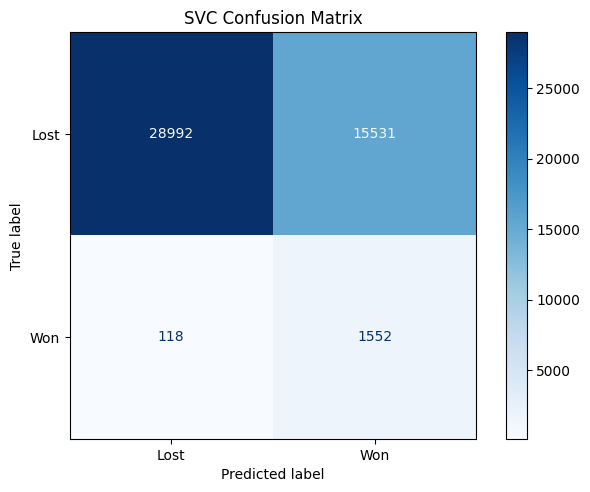

<Figure size 640x480 with 0 Axes>

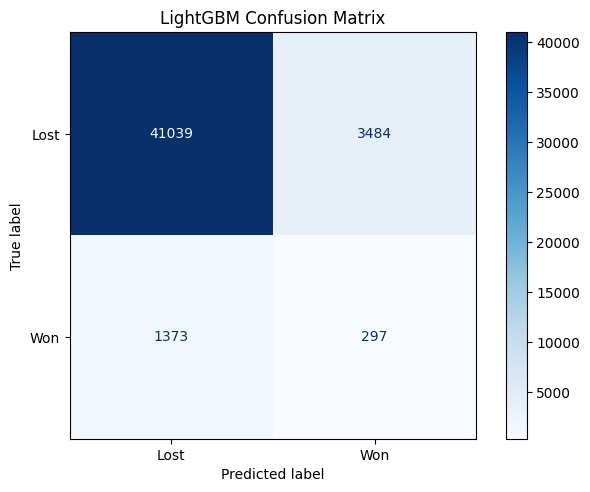

<Figure size 640x480 with 0 Axes>

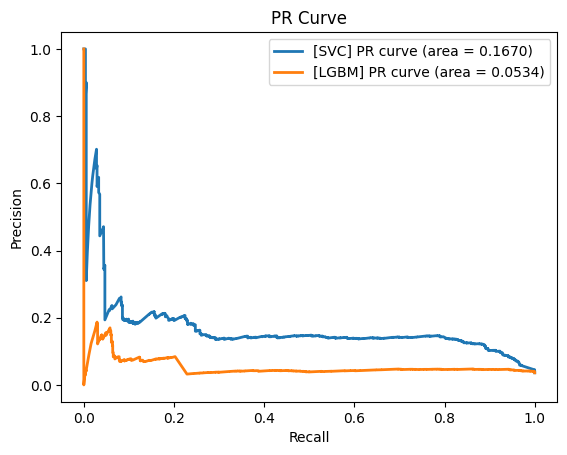

In [351]:
def plot_confusion_matrix(y_true, y_pred, classes, order, title=None, normalize=None):    
    plt.clf()
    if not title:
        title = 'Confusion Matrix, Without Normalization'

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap=plt.cm.Blues, labels=order)
    fig.tight_layout()
    ax.set(title=title, xticklabels=classes, yticklabels=classes)
    plt.show()


def plot_pr_auc(y_true, y_pred, labels=None, title="PR Curve"):    
    plt.clf()
    fig, ax = plt.subplots()
    if labels:
        for label, pred in zip(labels, y_pred):
            precision, recall, _ = precision_recall_curve(y_true, pred)
            pr_auc = auc(recall, precision)
            ax.plot(recall, precision, lw=2, label=f'[{label}] PR curve (area = {pr_auc:.4f})')
    else:
        ax.plot(recall, precision, lw=2, label=f'[Model] PR curve (area = {pr_auc:.4f})')
        
    ax.set(xlabel='Recall', ylabel='Precision', title=title)
    ax.legend(loc='upper right')
    plt.show()

test.target = test.target.astype(int)
print(f"SVC  Precision={precision_score(test.target, test.svc_pred):.4f} Recall={recall_score(test.target, test.svc_pred)}")
print(f"LGBM Precision={precision_score(test.target, test.lgbm_pred):.4f} Recall={recall_score(test.target, test.lgbm_pred)}")
plot_confusion_matrix(test.target.astype(int), test.svc_pred, ['Lost', 'Won'], [0, 1], title="SVC Confusion Matrix")
plot_confusion_matrix(test.target.astype(int), test.lgbm_pred, ['Lost', 'Won'], [0, 1], title="LightGBM Confusion Matrix")
plot_pr_auc(test.target.astype(int), [test.svc_proba, test.lgbm_proba], labels=['SVC', 'LGBM'])
